# Architecture CNN
Train a CNN model then test it on the full picture and save the resulting image.

In [1]:
import matplotlib.pyplot as matPlt
import random
import numpy as np

import tensorflow as tf
import keras
from keras import layers
from tqdm.keras import TqdmCallback

import math
from shapely.geometry import Polygon

import rasterio
from rasterio import plot as rastPlt
from rasterio.mask import mask as rasterMask

import junodch_utils_read_img as utils

# Data preparation
### Fetch data from files
Extract the area covered by the image by the satellite (sentinel-2) and extracte all pixels coordinates from the night image (VIIRS).
dataCoords will be use to fetch the individual training and testing tile for the machine learning model. dataRadiance contains the light intensity of each tile.
dataCoords and dataRadiance have the same size and each entry matches the same tile.
the only variable that sould be changed is folderName after fetching the data from 1-fetch-data and merging them in 2-image-merge.

In [723]:
folderName = "img/Ethiopie/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])

Tiles: 137637


#### Prepare Validation
Extract the data from GHSL. This is not a perfect metric for validation but will be use to filter some of the data used before training.

In [724]:
with rasterio.open(pathValidation) as f:
  sampleTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True) # arbitrary coordinate for a shape sample
print('Validation shape:',sampleTile.shape) # shape sample

print('Process validation...')
# If any of the pixels have a settlement then true else false
getValid = lambda data : [ 0.9 < img.max() for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=sampleTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


#### Fetch images
Fetch the images to use for the training of the model.
As muche as possible we want to be sure that the lightCoords matches tiles containing human settlement pictures and darkCoords matches tiles that are not human settlement.
This is why the resultValid is used to mask some of the data.

In [725]:
lightMask = (dataRadiance>0) & (resultValid == 1)
darkMask = (dataRadiance==0) & (resultValid == 0)

lightCoords = dataCoords[lightMask]

ratioDark = 2

# version with random index
'''
idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[darkMask], len(lightCoords)*ratioDark, replace=False)
darkCoords = dataCoords[idxDarkData]
'''

# Version with fixed index
steps = math.floor(dataCoords.shape[0]/(len(lightCoords)*ratioDark))
darkCoords = dataCoords[darkMask][::steps]

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=64)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

train = trainData
validationWeight = np.concatenate((dataRadiance[lightMask], dataRadiance[darkMask][::steps]))*ratioDark+1
validation = np.asarray([1 if rad > 1 else 0 for rad in validationWeight])

(5210, 64, 64, 3)
Light Tile: 1881
dark Tile: 3329
Total train (5210, 64, 64, 3)


## CNN
By default, an unchanged adam optimizer with mse loss function and a relu activation function.  
The default layers have : [16, 16, 16] filters and 128 perceptrons
The original picture is supposed to be 64x64 pixels and it's reduce into a 8x8 pixels before being flatten.  
The final result is one value between 0 and 1.  
0 means no human settlement so no light. 1 means light so human settlement.

In [726]:
# Input encoder
input_shape = keras.Input(shape=trainData.shape[1:])

optimizer = keras.optimizers.Adam(
  learning_rate=0.0002,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(input_shape)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)
cnn = layers.Conv2D(16,(3,3), 2, padding='same', activation=activationFunction)(cnn)

cnn = layers.Flatten()(cnn)
cnn = layers.Dense(128, activation=activationFunction)(cnn)
cnn = layers.Dense(1, activation='sigmoid')(cnn)

modelCNN = keras.Model(input_shape, cnn)
modelCNN.compile(optimizer=optimizer, loss=lossFunction)

result = modelCNN.fit(
  x=train[::2],
  y=validation[::2],
  epochs=20,
  batch_size=4,
  sample_weight=validationWeight[::2],
  verbose=0,
  validation_data=(train[1::2], validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_86 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_275 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_276 (Conv2D)         (None, 16, 16, 16)        2320      
                                                                 
 conv2d_277 (Conv2D)         (None, 8, 8, 16)          2320      
                                                                 
 flatten_85 (Flatten)        (None, 1024)              0         
                                                                 
 dense_100 (Dense)           (None, 128)               131200    
                                                                 
 dense_101 (Dense)           (None, 1)                 129

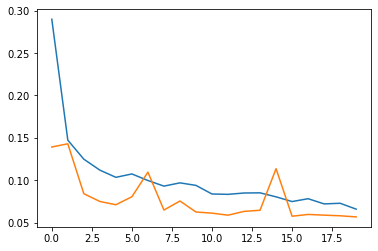

In [727]:
matPlt.plot(result.history['loss'][:], label='Training')
matPlt.plot(result.history['val_loss'][:], label='test')
modelCNN.summary()

## Analyse model
Calculate all tiles prediction by the model.

In [728]:
print('Process score...')
getScore = lambda data : modelCNN.predict(data, verbose=0).flatten()
#result = utils.scanSatellite(pathSatellite, trainCoords, getScore, batch=1000, res=64)
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=1000, res=64)

Process score...


### Get the confusion matrix.  
**Adjust "threshold" !**

The matrix is calculated by comparing the prediction against the GHSL data contained in resultValid.
There are no garantees that a false negative or positive are truly false. This will require to be check manually to the file 4-validation-map.ipynb

In [738]:
threshold = 0.35
resultTest = (np.asarray(result) > threshold).astype(int)

#utils.processConfusionMatrix(resultTest, validation, [True]*len(lightCoords)+[False]*len(darkCoords))
utils.processConfusionMatrix(resultTest, resultValid, lightMask)

Total light data: 1881 Detected: 1703 Missed: 178
Population with light detected: 90.54 %

Process confustion matrix...
total data: 137637
[[114815   5600]
 [ 12926   4296]]
f-score: 31.68 %


Test false positif


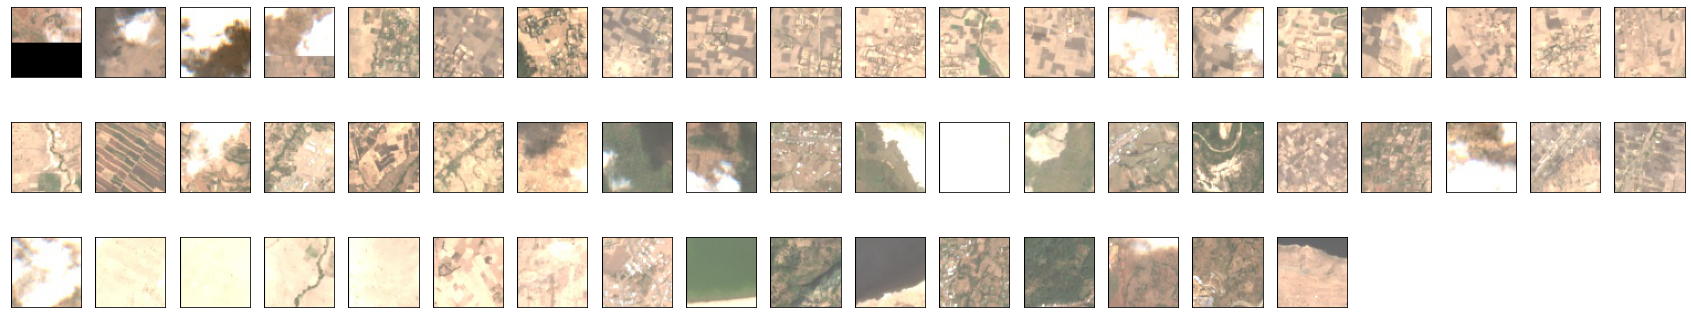

In [739]:
print("Test false positif")

fpTest = dataCoords[(resultTest == 1) & (resultValid == 0)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.coordsToImgsFormated(f, fpTest[::100], res=64)

utils.displayImgs(dataTest)

# Display the analysed results
On the left is the original image  
On the right is the GHSL data  
In the center is the resulting image of the model   
  
Green means tp: This is a human settlement by the model prediction and by GHSL  
Purple means tn: This is not a human settlement by the model prediction and by GHSL  
Blue means fp: The prediction says this is a human settlement but GHSL does not.  
Red means fn: The prediction did not said that was a human settlement but GHSL say there is and there is light too.  

In otherword : Green is good, red is bad but the rest must be double check in the file 4-validation-model.

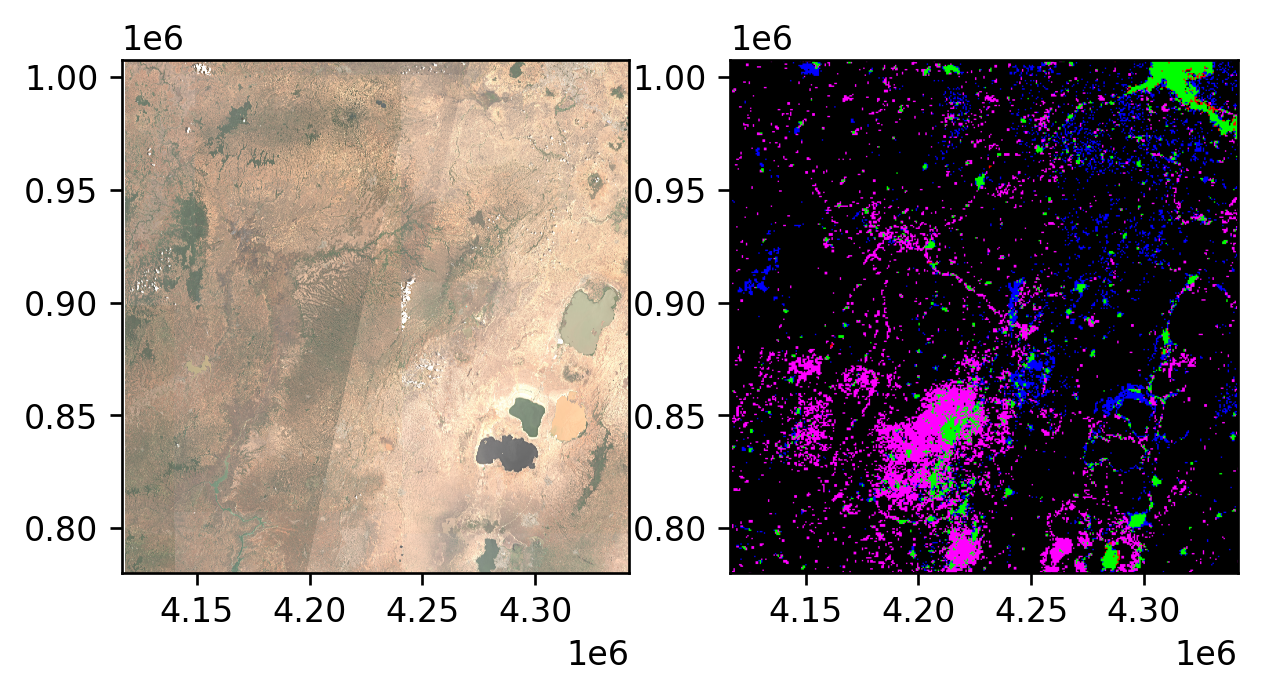

In [740]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid, lightMask)

fig, axs = matPlt.subplots(1,2, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])


In [741]:
# quick display
'''
newColorMap = {
  (0,0,0): (0,0,0),
  (0,0,1): (0,0,0),
  (0,1,0): (255,0,255),
  (0,1,1): (255,0,0),
  (1,0,0): (0,0,255),
  (1,0,1): (0,255,0),
  (1,1,0): (0,255,0),
  (1,1,1): (0,255,0),
}

resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid, lightMask, colorMap=newColorMap)
fig, axs = matPlt.subplots(1,1, dpi=240)
utils.displayTiles([resultImg], [resultMeta], axs)
'''

'\nnewColorMap = {\n  (0,0,0): (0,0,0),\n  (0,0,1): (0,0,0),\n  (0,1,0): (255,0,255),\n  (0,1,1): (255,0,0),\n  (1,0,0): (0,0,255),\n  (1,0,1): (0,255,0),\n  (1,1,0): (0,255,0),\n  (1,1,1): (0,255,0),\n}\n\nresultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid, lightMask, colorMap=newColorMap)\nfig, axs = matPlt.subplots(1,1, dpi=240)\nutils.displayTiles([resultImg], [resultMeta], axs)\n'

# Sauvegarde de l'image et du model

In [742]:
modelCNN.save('model/cnn_64px_conv16_conv16_conv16_dense128_Ethiopie')

INFO:tensorflow:Assets written to: model/cnn_64px_conv16_conv16_conv16_dense128_Ethiopie\assets


INFO:tensorflow:Assets written to: model/cnn_64px_conv16_conv16_conv16_dense128_Ethiopie\assets


In [743]:
img, profile = utils.rasterToImg(resultImg, pathNight)
with rasterio.open(folderName + 'cnn_64px_conv16_conv16_conv16_dense128_Ethiopie.tif', 'w', **profile) as f:
  f.write(img)
